In [1]:
!pip install lightning-utilities
!pip install torchmetrics --no-deps
!pip install torchinfo --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 44.0 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2
from torchvision.transforms.functional import to_pil_image
from torchmetrics import Accuracy,ConfusionMatrix,Precision,Recall,F1Score,MeanMetric
from torchinfo import summary
from tqdm import tqdm

In [3]:
device='cuda' if torch.cuda.is_available() \
        else 'mps' if torch.mps.is_available() \
        else 'cpu'
print('Device:',device)

Device: cuda


In [4]:
!unzip archive.zip -d raf-db-datset

Streaming output truncated to the last 5000 lines.
  inflating: raf-db-datset/DATASET/train/5/train_00987_aligned.jpg  
  inflating: raf-db-datset/DATASET/train/5/train_00990_aligned.jpg  
  inflating: raf-db-datset/DATASET/train/5/train_00991_aligned.jpg  
  inflating: raf-db-datset/DATASET/train/5/train_00992_aligned.jpg  
  inflating: raf-db-datset/DATASET/train/5/train_01002_aligned.jpg  
  inflating: raf-db-datset/DATASET/train/5/train_01010_aligned.jpg  
  inflating: raf-db-datset/DATASET/train/5/train_01011_aligned.jpg  
  inflating: raf-db-datset/DATASET/train/5/train_01013_aligned.jpg  
  inflating: raf-db-datset/DATASET/train/5/train_01015_aligned.jpg  
  inflating: raf-db-datset/DATASET/train/5/train_01017_aligned.jpg  
  inflating: raf-db-datset/DATASET/train/5/train_01039_aligned.jpg  
  inflating: raf-db-datset/DATASET/train/5/train_01048_aligned.jpg  
  inflating: raf-db-datset/DATASET/train/5/train_01049_aligned.jpg  
  inflating: raf-db-datset/DATASET/train/5/train_010

In [5]:
train_transform=v2.Compose([
    v2.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomResizedCrop(size=224,scale=(0.5,1.0)),
    v2.ToImage(),
    v2.ToDtype(torch.float32,scale=True),
    v2.Normalize(mean=[0.485,0.456,0.406],
                 std=[0.229,0.224,0.225])
])


In [6]:
eval_transform=v2.Compose([
    v2.Resize(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32,scale=True),
    v2.Normalize(mean=[0.485,0.456,0.406],
                 std=[0.229,0.224,0.225])
])

In [7]:
train_data=torchvision.datasets.ImageFolder('raf-db-datset/DATASET/train',transform=train_transform)
val_data=torchvision.datasets.ImageFolder('raf-db-datset/DATASET/train',transform=eval_transform)
test_set=torchvision.datasets.ImageFolder('raf-db-datset/DATASET/test',transform=eval_transform)

In [8]:
train_size=int(0.8*len(train_data))
val_size=len(train_data)-train_size
train_indices,val_indices=torch.utils.data.random_split(range(len(train_data)),[train_size,val_size])

#train_data and val_data have different transforms
train_set=torch.utils.data.Subset(train_data,train_indices)
val_set=torch.utils.data.Subset(val_data,val_indices)

In [9]:
train_dataloader=torch.utils.data.DataLoader(train_set,batch_size=32,shuffle=True)
val_dataloader=torch.utils.data.DataLoader(val_set,batch_size=32,shuffle=False)
test_dataloader=torch.utils.data.DataLoader(test_set,batch_size=32,shuffle=False)

In [10]:
classes=['Surprise','Fear','Disgust','Happiness','Sadness','Anger','Neutral']
num_class=len(classes)
print('Number of Classes:',num_class)

Number of Classes: 7


In [11]:
print('Number of Train Sample:',len(train_set))
print('Number of Val Sample:',len(val_set))
print('Number of Test Sample:',len(test_set))

Number of Train Sample: 9816
Number of Val Sample: 2455
Number of Test Sample: 3068


In [12]:
def count_class_sample_number(dataset,classes):
  #Get the labels of all the Data in the Training set
  labels=[dataset[i][1] for i in range(len(dataset))]
  #count the number of data per class
  class_counts=np.bincount(labels)
  #Print the number of samples per class
  for class_label, count in enumerate(class_counts):
    print('Class',classes[class_label],'has',count,'Samples.')

In [13]:
print('Train:')
count_class_sample_number(train_set,classes)
print('Validation:')
count_class_sample_number(val_set,classes)
print('Test:')
count_class_sample_number(test_set,classes)

Train:
Class Surprise has 1033 Samples.
Class Fear has 220 Samples.
Class Disgust has 561 Samples.
Class Happiness has 3802 Samples.
Class Sadness has 1593 Samples.
Class Anger has 562 Samples.
Class Neutral has 2045 Samples.
Validation:
Class Surprise has 257 Samples.
Class Fear has 61 Samples.
Class Disgust has 156 Samples.
Class Happiness has 970 Samples.
Class Sadness has 389 Samples.
Class Anger has 143 Samples.
Class Neutral has 479 Samples.
Test:
Class Surprise has 329 Samples.
Class Fear has 74 Samples.
Class Disgust has 160 Samples.
Class Happiness has 1185 Samples.
Class Sadness has 478 Samples.
Class Anger has 162 Samples.
Class Neutral has 680 Samples.


In [14]:
def denormalize(tensor):
  #Reshape to match image dimentions
  mean=torch.tensor([0.485,0.456,0.406]).reshape(3,1,1)
  std=torch.tensor([0.229,0.224,0.225]).reshape(3,1,1)
  return tensor * std + mean

#function: Visualize traing image for each class
def visualize_data(dataset, classes, transform=None):
  sample_images = []
  for class_i in range(len(classes)):
    # ImageFolder dataset.imgs stores (image_patch, label)
    found_image = False  # Flag to track if image is found for current class
    for image_path, label in dataset.imgs:
      if label == class_i:
        image = Image.open(image_path)
        if transform:
          image = transform(image)
          image = denormalize(image)
          # Convert back to PIL image format
          image = to_pil_image(image.clamp(0, 1))
        sample_images.append(image)
        found_image = True
        break  # Break inner loop once an image is found for the class

    # If no image found for the class, append a placeholder (e.g., a blank image)
    if not found_image:
      sample_images.append(Image.new('RGB', (224, 224), color='white'))  # Placeholder
      print(f"Warning: No image found for class {classes[class_i]}. Using a placeholder.")

  # Show images
  fig, axes = plt.subplots(1, len(classes), figsize=(10, 3))
  for i, axis in enumerate(axes.flat):
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=12)
    axis.imshow(sample_images[i])  # Now sample_images should have an image for each class

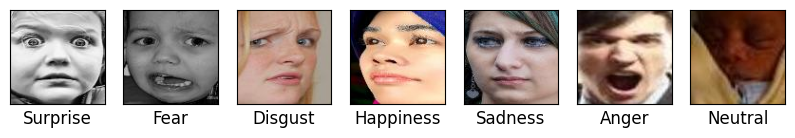

In [15]:
#without data aug
visualize_data(train_data,classes)

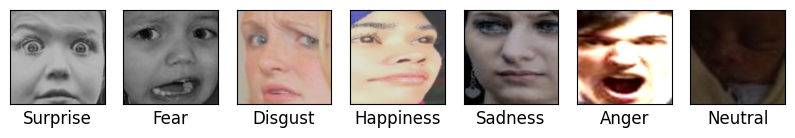

In [16]:
#with data aug
visualize_data(train_data,classes,train_transform)

In [17]:
model=torchvision.models.resnet18('IMAGENET1K_V1')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 205MB/s]


In [18]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
model.fc=nn.Linear(model.fc.in_features,num_class)

In [20]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [50]:
criteria=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)

In [51]:
# a function for training one epoch
def train_one_epoch(model, dataloader):
    # Prepare for storing loss and accuracy
    losses = MeanMetric().to(device)
    acc = Accuracy(task='multiclass', num_classes=num_class).to(device) #num_classes should match the actual number of classes in your dataset
    model.to(device) # Move the model to the appropriate device
    model.train() # set model to train mode
    # a loop to iterate input(X) and label(Y) for all mini-batches
    for X, Y in tqdm(dataloader):
        X = X.to(device)
        Y = Y.to(device)
        optimizer.zero_grad() # reset optimizer
        preds = model(X) # model forward
        loss = criteria(preds, Y) # calculate loss
        loss.backward() # compute gradients via backpropagation
        optimizer.step() # perform gradient descent
        preds = preds.argmax(dim=1) # obtain the final predicted class
        losses.update(loss, X.size(0)) # store loss per batch
        acc.update(preds, Y) # store accuracy per batch
    return losses.compute().item(), acc.compute().item()

In [52]:
# a function for validation one epoch
def validation_one_epoch(model, dataloader):
    # Prepare for storing loss and accuracy
    losses = MeanMetric().to(device)
    acc = Accuracy(task='multiclass', num_classes=num_class).to(device) #num_classes should match the actual number of classes in your dataset
    model.to(device) # Move the model to the appropriate device
    model.eval() # set model to validation mode
    with torch.no_grad(): # disables gradient computation for evaluation
    # a loop to iterate input(X) and label(Y) for all mini-batches
        for X, Y in tqdm(dataloader):
            X = X.to(device)
            Y = Y.to(device)
            preds = model(X) # model forward
            loss = criteria(preds, Y) # calculate loss
            preds = preds.argmax(dim=1) # obtain the final predicted class
            losses.update(loss, X.size(0)) # store loss per batch
            acc.update(preds, Y) # store accuracy per batch
        return losses.compute().item(), acc.compute().item()

In [53]:
# Prepare for storing loss and accuracy
history = pd.DataFrame() # store statics for each epoch
epochs = 15 # number of epochs

# a loop for epochs
for i in range(0, epochs):
  # train one epoch
  train_loss, train_acc = train_one_epoch(model, train_dataloader)
  # validation one epoch
  val_loss, val_acc = validation_one_epoch(model, val_dataloader)

  # store and print loss and accuracy per epoch
  statistics = pd.DataFrame({
      "epoch": [i],
      "train_loss": [train_loss],
      "train_acc": [train_acc],
      "val_loss": [val_loss],
      "val_acc": [val_acc]
  })

  history = pd.concat([history, statistics], ignore_index=True)
  print(statistics.to_dict(orient="records")[0])

100%|██████████| 77/77 [00:08<00:00,  8.98it/s]


{'epoch': 0, 'train_loss': 0.6747736930847168, 'train_acc': 0.7564181089401245, 'val_loss': 0.7071376442909241, 'val_acc': 0.7498981952667236}


100%|██████████| 77/77 [00:08<00:00,  9.59it/s]


{'epoch': 1, 'train_loss': 0.6483579874038696, 'train_acc': 0.7620211839675903, 'val_loss': 0.6876465082168579, 'val_acc': 0.7613034844398499}


100%|██████████| 77/77 [00:08<00:00,  8.80it/s]


{'epoch': 2, 'train_loss': 0.6340173482894897, 'train_acc': 0.7708842754364014, 'val_loss': 0.6866159439086914, 'val_acc': 0.7584521174430847}


100%|██████████| 77/77 [00:08<00:00,  8.95it/s]


{'epoch': 3, 'train_loss': 0.6246289610862732, 'train_acc': 0.7750611305236816, 'val_loss': 0.6661667227745056, 'val_acc': 0.7674134373664856}


100%|██████████| 77/77 [00:08<00:00,  9.09it/s]


{'epoch': 4, 'train_loss': 0.6243278384208679, 'train_acc': 0.7751629948616028, 'val_loss': 0.6687332391738892, 'val_acc': 0.7608961462974548}


100%|██████████| 77/77 [00:08<00:00,  9.02it/s]


{'epoch': 5, 'train_loss': 0.61484694480896, 'train_acc': 0.7785248756408691, 'val_loss': 0.6600794792175293, 'val_acc': 0.7690427899360657}


100%|██████████| 77/77 [00:07<00:00,  9.90it/s]


{'epoch': 6, 'train_loss': 0.6127707958221436, 'train_acc': 0.7844336032867432, 'val_loss': 0.6587422490119934, 'val_acc': 0.7690427899360657}


100%|██████████| 77/77 [00:08<00:00,  8.92it/s]


{'epoch': 7, 'train_loss': 0.5959972143173218, 'train_acc': 0.7832111120223999, 'val_loss': 0.6670046448707581, 'val_acc': 0.7645621299743652}


100%|██████████| 77/77 [00:08<00:00,  9.08it/s]


{'epoch': 8, 'train_loss': 0.5946669578552246, 'train_acc': 0.7907497882843018, 'val_loss': 0.66009122133255, 'val_acc': 0.7743380665779114}


100%|██████████| 77/77 [00:08<00:00,  8.85it/s]


{'epoch': 9, 'train_loss': 0.5934386253356934, 'train_acc': 0.7887123227119446, 'val_loss': 0.6678858399391174, 'val_acc': 0.771894097328186}


100%|██████████| 77/77 [00:08<00:00,  9.02it/s]


{'epoch': 10, 'train_loss': 0.5740712881088257, 'train_acc': 0.7926853895187378, 'val_loss': 0.6557801961898804, 'val_acc': 0.7731161117553711}


100%|██████████| 77/77 [00:07<00:00,  9.81it/s]


{'epoch': 11, 'train_loss': 0.5717012882232666, 'train_acc': 0.7924816608428955, 'val_loss': 0.648819625377655, 'val_acc': 0.7767820954322815}


100%|██████████| 77/77 [00:08<00:00,  9.05it/s]


{'epoch': 12, 'train_loss': 0.5696970820426941, 'train_acc': 0.7942135334014893, 'val_loss': 0.6466378569602966, 'val_acc': 0.7739307284355164}


100%|██████████| 77/77 [00:07<00:00,  9.76it/s]


{'epoch': 13, 'train_loss': 0.5678176283836365, 'train_acc': 0.7954360246658325, 'val_loss': 0.6442669630050659, 'val_acc': 0.7747454047203064}


100%|██████████| 77/77 [00:08<00:00,  8.91it/s]

{'epoch': 14, 'train_loss': 0.555600643157959, 'train_acc': 0.7990016341209412, 'val_loss': 0.6420478820800781, 'val_acc': 0.7788187265396118}


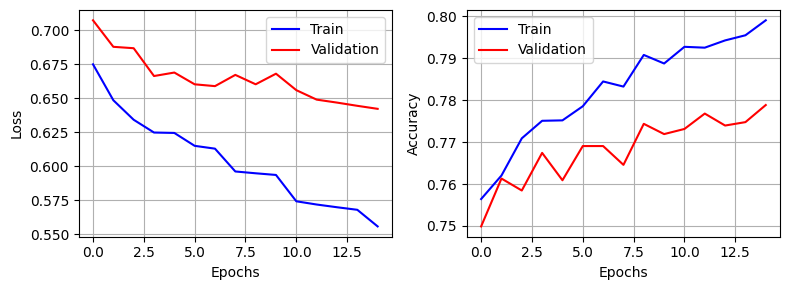

In [54]:
# Create a figure with two subplots (side by side)
plt.figure(figsize=(8, 3))

# Plot Loss Curve (Train + Validation)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(history["epoch"], history["train_loss"], label="Train", color="blue")
plt.plot(history["epoch"], history["val_loss"], label="Validation", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy Curve (Train + Validation)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.plot(history["epoch"], history["train_acc"], label="Train", color="blue")
plt.plot(history["epoch"], history["val_acc"], label="Validation", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [55]:
# prepare for storing evaluation metrics
test_acc = Accuracy(task='multiclass', num_classes=num_class).to(device)
test_confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=num_class).to(device)
test_precision = Precision(task="multiclass", num_classes=num_class, average="macro").to(device)
test_recall = Recall(task="multiclass", num_classes=num_class, average="macro").to(device)
test_f1_score = F1Score(task="multiclass", num_classes=num_class, average="macro").to(device)

model = model.to(device)
model.eval()  # set model to evaluation mode
with torch.no_grad():
    for X, Y in test_dataloader:
        X = X.to(device)
        Y = Y.to(device)
        preds = model(X)  # model forward
        preds = preds.argmax(dim=1)  # obtain the final predicted class

        # store loss and accuracy per batch
        test_confusion_matrix.update(preds, Y)
        test_acc.update(preds, Y)
        test_precision.update(preds, Y)
        test_recall.update(preds, Y)
        test_f1_score.update(preds, Y)

    # Print the results
    print("Confusion Matrix:\n", test_confusion_matrix.compute())
    print("Accuracy:", test_acc.compute().item())
    print("Precision:", test_precision.compute().item())
    print("Recall:", test_recall.compute().item())
    print("F1 Score:", test_f1_score.compute().item())

Confusion Matrix:
 tensor([[ 263,    4,    7,   14,    9,    3,   29],
        [  17,   23,    3,    8,   11,    7,    5],
        [   7,    0,   60,   17,   15,   15,   46],
        [  15,    0,   18, 1078,   28,    9,   37],
        [   6,    1,   24,   39,  325,   12,   71],
        [   8,    4,   13,   14,    8,  104,   11],
        [  16,    1,   20,   39,   66,    5,  533]], device='cuda:0')
Accuracy: 0.7777053713798523
Precision: 0.6995929479598999
Recall: 0.6429461240768433
F1 Score: 0.6603280305862427


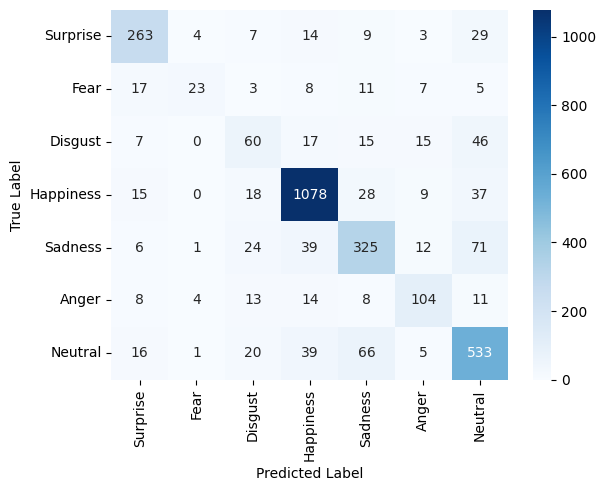

In [56]:
# Create a heatmap for better confusion matrix visualization
sns.heatmap(test_confusion_matrix.compute().cpu(), annot=True, fmt="d",
            cmap="Blues", xticklabels=classes, yticklabels=classes)
# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

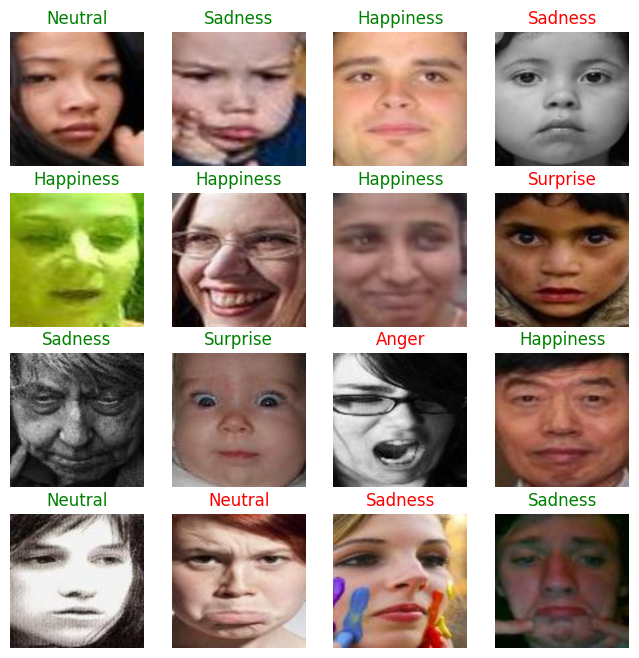

In [57]:
# Define denormalization transform
def denormalize(tensor):
    # Reshape to match image dimensions
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    return tensor * std + mean  # Reverse normalization

# shuffle the test data to have samples from all classes
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

# obtain one batch of test images
images, labels = next(iter(test_dataloader))

# move model to cpu
model = model.to('cpu')

# get sample outputs
model.eval()
with torch.no_grad():
    preds = model(images)  # model forward
    preds = preds.argmax(dim=1)  # obtain the final predicted class

# Create a 4x4 grid for displaying the images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

# Iterate over the images and display them in the grid
for idx, ax in enumerate(axes.flat):
    image = images[idx]  # get one image
    image = denormalize(image)  # denormalize
    # convert back to PIL image format
    image = to_pil_image(image.clamp(0, 1))
    ax.imshow(image)  # Display the image
    ax.axis('off')  # Hide the axes
    # Add title to the image
    # green: correct prediciton, red: incorrect prediction
    ax.set_title("{}".format(classes[preds[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

plt.show()